In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image
from tqdm import tqdm

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [2]:
##### AutoEncoder 모델 코드 #####

class Inverse_MaxPool2(torch.autograd.Function):
    def __init__(self):
      super(Inverse_MaxPool2, self).__init__()

    def forward(self, x_in):
      x_in_dim = x_in.size() #ex) x_in_dim = [128, 64, 50, 50]
      x_out = torch.zeros((x_in_dim[0],
                          x_in_dim[1],
                          x_in_dim[2]*2,
                          x_in_dim[3]*2)).to(device) #ex) x_out_dim = [128, 64, 100, 100]
      for k in range(x_in_dim[2]):
        for l in range(x_in_dim[3]):
          x_out[:,:,2*k:2*k+1,2*l:2*l+1] = x_in[:,:,k:k+1,l:l+1]  #inverse MaxPool
      
      return x_out

    def backward(self, x_in):
      x_in_dim = x_in.size() #ex) x_in_dim = [128, 64, 100, 100]
      x_out = torch.zeros((x_in_dim[0],
                          x_in_dim[1],
                          int((x_in_dim[2])/2),
                          int((x_in_dim[3])/2))).to(device) #ex) x_out_dim = [128, 64, 50, 50]
                          
      for k in range(int((x_in_dim[2])/2)):
        for l in range(int((x_in_dim[3])/2)):
          x_out[:,:,k:k+1,l:l+1] = x_in[:,:,2*k:2*k+1,2*l:2*l+1]  #inverse MaxPool
      
      return x_out

class Inverse_MaxPool3(torch.autograd.Function):
    def __init__(self):
      super(Inverse_MaxPool3, self).__init__()

    def forward(self, x_in):
      x_in_dim = x_in.size() #ex) x_in_dim = [128, 64, 13, 13]
      x_out = torch.zeros((x_in_dim[0],
                          x_in_dim[1],
                          x_in_dim[2]*2-1,
                          x_in_dim[3]*2-1)).to(device) #ex) x_out_dim = [128, 64, 25, 25]
      for k in range(x_in_dim[2]):
        for l in range(x_in_dim[3]):
          x_out[:,:,2*k:2*k+1,2*l:2*l+1] = x_in[:,:,k:k+1,l:l+1]  #inverse MaxPool
      
      return x_out

    def backward(self, x_in):
      x_in_dim = x_in.size() #ex) x_in_dim = [128, 64, 25, 25]
      x_out = torch.zeros((x_in_dim[0],
                          x_in_dim[1],
                          int((x_in_dim[2]+1)/2),
                          int((x_in_dim[3]+1)/2))).to(device) #ex) x_out_dim = [128, 64, 13, 13]
                          
      for k in range(int((x_in_dim[2]+1)/2)):
        for l in range(int((x_in_dim[3]+1)/2)):
          x_out[:,:,k:k+1,l:l+1] = x_in[:,:,2*k:2*k+1,2*l:2*l+1]  #inverse MaxPool
      
      return x_out

class Encoder(nn.Module):
    def __init__(self):
      super(Encoder, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
      self.conv2 = nn.Conv2d(16, 64, 3, 1, 1)
      self.conv3 = nn.Conv2d(64, 144, 3, 1, 1)
      self.conv4 = nn.Conv2d(144,256, 3, 1, 1)
      self.conv5 = nn.Conv2d(256,400, 3, 1, 1)
      
      self.pool2 = nn.MaxPool2d(2, 2, 0)
      self.pool3 = nn.MaxPool2d(3, 2, 1)

      self.activation = nn.ReLU()
      
      self.bn1 = nn.BatchNorm2d(16)
      self.bn2 = nn.BatchNorm2d(64)
      self.bn3 = nn.BatchNorm2d(144)
      self.bn4 = nn.BatchNorm2d(256)
      self.bn5 = nn.BatchNorm2d(400)

    def forward(self, x):
      x = self.pool2(self.activation(self.bn1(self.conv1(x))))
      x = self.pool2(self.activation(self.bn2(self.conv2(x)))) 
      x = self.pool3(self.activation(self.bn3(self.conv3(x)))) 
      x = self.pool3(self.activation(self.bn4(self.conv4(x)))) 
      x = self.pool3(self.activation(self.bn5(self.conv5(x)))) 
      #print(np.shape(x))
      return x

IMP2 = Inverse_MaxPool2().apply
IMP3 = Inverse_MaxPool3().apply

class Decoder(nn.Module):
    def __init__(self):
      super(Decoder, self).__init__()

      self.deconv1 = nn.Conv2d(400, 256, 3, 1, 1)
      self.deconv2 = nn.Conv2d(256, 144, 3, 1, 1)
      self.deconv3 = nn.Conv2d(144, 64, 3, 1, 1)
      self.deconv4 = nn.Conv2d(64, 16, 3, 1, 1)
      self.deconv5 = nn.Conv2d(16, 3, 3, 1, 1)
      
      self.bn1 = nn.BatchNorm2d(256)
      self.bn2 = nn.BatchNorm2d(144)
      self.bn3 = nn.BatchNorm2d(64)
      self.bn4 = nn.BatchNorm2d(16)
      
      self.activation = nn.ReLU()

    def forward(self, x):
      x = self.activation(self.bn1(self.deconv1(IMP3(x))))
      x = self.activation(self.bn2(self.deconv2(IMP3(x))))
      x = self.activation(self.bn3(self.deconv3(IMP3(x))))
      x = self.activation(self.bn4(self.deconv4(IMP2(x))))
      x = self.deconv5(IMP2(x))
      return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        z = self.encoder(input)
        x_hat = self.decoder(z)
        return z, x_hat

In [3]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/",  
                    split='train',
                    transform=transform,
                    download = True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split = 'test',
                    transform=transform,
                    download = True)

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

100%|██████████| 344862509/344862509 [00:24<00:00, 13944167.68it/s]


Extracting StanfordCars/flowers-102/102flowers.tgz to StanfordCars/flowers-102


100%|██████████| 502/502 [00:00<00:00, 377404.66it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13599053.14it/s]


Epoch : 1 / 40, cost : 0.3487110733985901
Epoch : 2 / 40, cost : 0.2628292739391327
Epoch : 3 / 40, cost : 0.2147248089313507
Epoch : 4 / 40, cost : 0.18017426133155823
Epoch : 5 / 40, cost : 0.15418902039527893


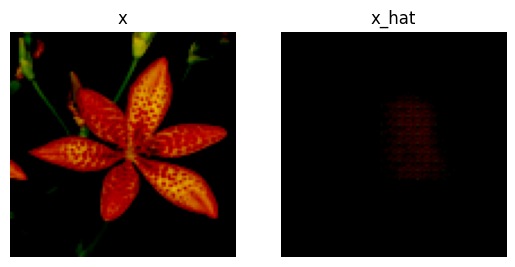

Epoch : 6 / 40, cost : 0.13739661872386932
Epoch : 7 / 40, cost : 0.1254953145980835
Epoch : 8 / 40, cost : 0.11663930118083954
Epoch : 9 / 40, cost : 0.10963675379753113


Epoch : 10 / 40, cost : 0.10607227683067322


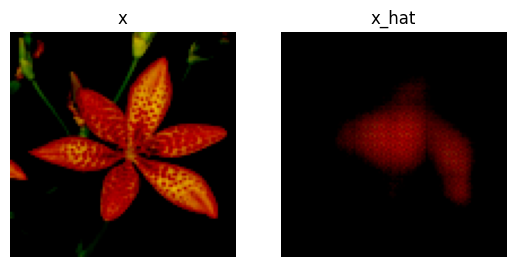

Epoch : 11 / 40, cost : 0.10234726220369339
Epoch : 12 / 40, cost : 0.09904590249061584
Epoch : 13 / 40, cost : 0.09644588828086853
Epoch : 14 / 40, cost : 0.09326032549142838


Epoch : 15 / 40, cost : 0.08932121098041534


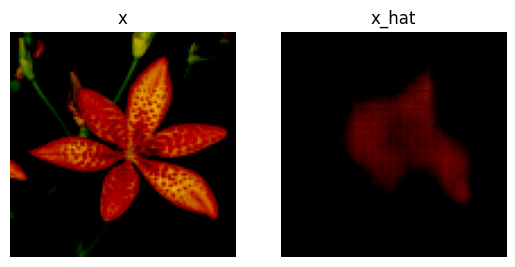

Epoch : 16 / 40, cost : 0.0856497660279274
Epoch : 17 / 40, cost : 0.08407452702522278
Epoch : 18 / 40, cost : 0.08056165277957916
Epoch : 19 / 40, cost : 0.07740553468465805


Epoch : 20 / 40, cost : 0.07653185725212097


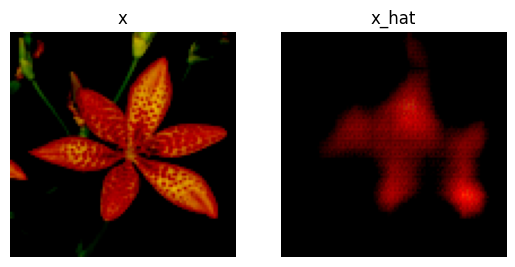

Epoch : 21 / 40, cost : 0.07697182893753052
Epoch : 22 / 40, cost : 0.07348360121250153
Epoch : 23 / 40, cost : 0.07198487967252731
Epoch : 24 / 40, cost : 0.07009924948215485


Epoch : 25 / 40, cost : 0.06866531074047089


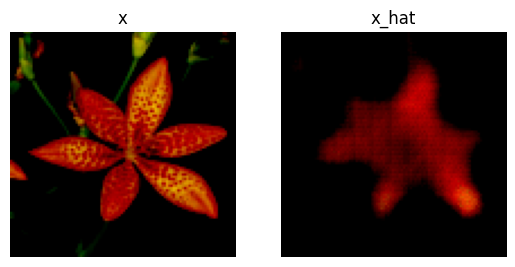

Epoch : 26 / 40, cost : 0.06667125970125198
Epoch : 27 / 40, cost : 0.06515848636627197
Epoch : 28 / 40, cost : 0.06394091993570328
Epoch : 29 / 40, cost : 0.06459980458021164


Epoch : 30 / 40, cost : 0.06294529885053635


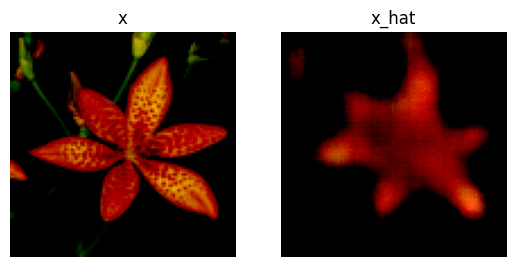

Epoch : 31 / 40, cost : 0.060918621718883514
Epoch : 32 / 40, cost : 0.06068042293190956
Epoch : 33 / 40, cost : 0.059753187000751495
Epoch : 34 / 40, cost : 0.058391496539115906


Epoch : 35 / 40, cost : 0.05812179297208786


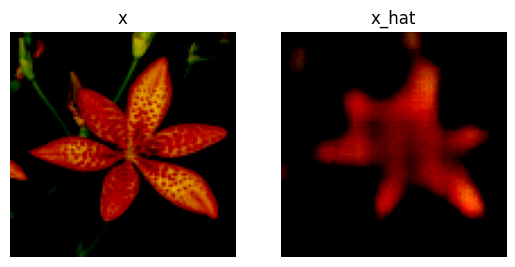

Epoch : 36 / 40, cost : 0.05696733668446541
Epoch : 37 / 40, cost : 0.05629071220755577
Epoch : 38 / 40, cost : 0.05589708313345909
Epoch : 39 / 40, cost : 0.05580568686127663


Epoch : 40 / 40, cost : 0.054674018174409866


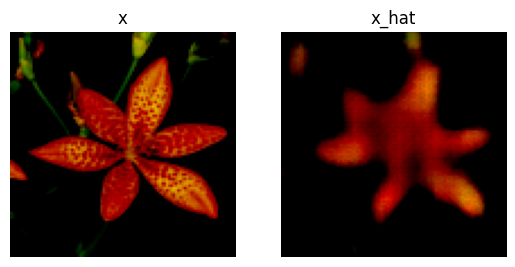

In [4]:
##### AutoEncoder 학습 코드 #####
import matplotlib.pyplot as plt
sample = train_dataset[1019][0].view(1,3,100,100).to(device)
autoencoder = AutoEncoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

epochs = 40

autoencoder.train()
for epoch in range(epochs):
  autoencoder.train()
  avg_cost = 0
  total_batch_num = len(train_dataloader)

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    z, b_x_hat = autoencoder(b_x)
    loss = criterion(b_x_hat, b_x)

    avg_cost += loss / total_batch_num
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

  if (epoch+1)%5 == 0:
    autoencoder.eval()
    fig, ax = plt.subplots(1,2)
    with torch.no_grad():
      test_z, test_output = autoencoder(sample)
    ax[0].set_title('x')
    ax[1].set_title('x_hat')

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[0].imshow(np.transpose(np.reshape(sample.cpu(),(3,100,100)),(1,2,0)))
    ax[1].imshow(np.transpose(np.reshape(test_output.cpu(),(3,100,100)),(1,2,0)))
    plt.show()

In [5]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
    def __init__(self, drop_prob):
      super(Classifier, self).__init__()
      self.conv1 = nn.Conv2d(400, 700, 3, 1, 1) 
      self.conv2 = nn.Conv2d(700, 1000, 3, 1, 1) 

      self.linear1 = nn.Linear(16*1000, 8192)
      self.linear2 = nn.Linear(8192, 2048)
      self.linear3 = nn.Linear(2048, 512)
      self.linear4 = nn.Linear(512, 102)

      self.bn1 = nn.BatchNorm2d(700)
      self.bn2 = nn.BatchNorm2d(1000)
      self.bn3 = nn.BatchNorm1d(8192)
      self.bn4 = nn.BatchNorm1d(2048)
      self.bn5 = nn.BatchNorm1d(512)

      self.dropout = nn.Dropout(drop_prob)
      self.activation = nn.ReLU()
        
    def forward(self, x):
      x = self.activation(self.bn1(self.conv1(x)))
      x = self.activation(self.bn2(self.conv2(x)))
      x = torch.flatten(x, 1)
      x = self.dropout(self.activation(self.bn3(self.linear1(x))))
      x = self.dropout(self.activation(self.bn4(self.linear2(x))))
      x = self.dropout(self.activation(self.bn5(self.linear3(x))))
      x = self.linear4(x)
      return x

In [7]:
##### Classifier 학습 코드 #####

classifier = Classifier(0.25).to(device)
autoencoder = AutoEncoder().to(device)
cls_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(
    [
        {"params" : autoencoder.parameters(), "lr" : 0.001},
        {"params" : classifier.parameters(), "lr" : 0.001}
    ]
)
autoencoder.train()
classifier.train()
total_batch_num = len(train_dataloader)

epochs = 40

for epoch in range(epochs):
  autoencoder.train()
  classifier.train()
  avg_cost = 0

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
    loss = cls_criterion(logits,b_y.to(device))

    avg_cost += loss / total_batch_num
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

Epoch : 1 / 40, cost : 4.480074405670166
Epoch : 2 / 40, cost : 3.9068288803100586
Epoch : 3 / 40, cost : 3.4901230335235596
Epoch : 4 / 40, cost : 3.1235954761505127
Epoch : 5 / 40, cost : 2.7313311100006104
Epoch : 6 / 40, cost : 2.3375277519226074
Epoch : 7 / 40, cost : 1.8036079406738281
Epoch : 8 / 40, cost : 1.3244014978408813
Epoch : 9 / 40, cost : 1.016998291015625
Epoch : 10 / 40, cost : 0.6052581071853638
Epoch : 11 / 40, cost : 0.42757320404052734
Epoch : 12 / 40, cost : 0.31802812218666077
Epoch : 13 / 40, cost : 0.2616255283355713
Epoch : 14 / 40, cost : 0.22171565890312195
Epoch : 15 / 40, cost : 0.19655808806419373
Epoch : 16 / 40, cost : 0.18063631653785706
Epoch : 17 / 40, cost : 0.16332130134105682
Epoch : 18 / 40, cost : 0.1503528356552124
Epoch : 19 / 40, cost : 0.1412210464477539
Epoch : 20 / 40, cost : 0.12939947843551636
Epoch : 21 / 40, cost : 0.12202630192041397
Epoch : 22 / 40, cost : 0.11410567909479141
Epoch : 23 / 40, cost : 0.10945171117782593
Epoch : 24 /

In [8]:
##### Classifier 정확도 측정 코드 #####

correct = 0
total = 0
classifier.eval()
autoencoder.eval()
for b_x, b_y in train_dataloader:
  b_x = b_x.to(device)
  with torch.no_grad():
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
  predicts = torch.argmax(logits, dim = 1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()

print(f'Accuracy of the network on train images: {100 * correct / total} %')

correct = 0
total = 0
for b_x, b_y in test_dataloader:
  b_x = b_x.to(device)
  with torch.no_grad():
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
  predicts = torch.argmax(logits, dim = 1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total} %')

Accuracy of the network on train images: 100.0 %
Accuracy of the network on test images: 41.16116441697837 %
